In [1]:
from collections import defaultdict

import logging
import os
import time

from bs4 import BeautifulSoup, element as bs4_element
import numpy as np
import pandas as pd

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

In [2]:
logging.basicConfig(format='%(asctime)s [%(levelname)s] %(message)s', 
                    datefmt='%d-%b-%y %H:%M:%S',
                    level=logging.INFO)

In [3]:
class LinkedIn:
    
    def __init__(self, snooze=2):
        
        logging.info('Setting Up LinkedIn')
        self.snooze = snooze
         

    def sign_in(self, username, password):
        logging.info('Login in LinkedIn')
        self.username = username
        self.password = password
        
        # Remove the Automation Info 
        chrome_options = webdriver.ChromeOptions()
        chrome_options.add_argument("--disable-infobars")
        driver = webdriver.Chrome(options=chrome_options)
        
        driver.get('https://www.linkedin.com/login')
    
        user_name = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, 'username'))
        )
        user_name.clear()
        user_name.send_keys(self.username)
    
        user_pwd = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, 'password'))
        )
        user_pwd.clear()
        user_pwd.send_keys(self.password)
        user_pwd.submit()
        
        self.driver = driver
        
        logging.info('Login Successful')
        return self
    
    def sign_off(self, soup=True):
        
        time.sleep(5)
        
        if soup:
            self.soup = BeautifulSoup(self.driver.page_source, 'lxml')
            logging.info('Logoff with soup')
            
        self.driver.close()
        logging.info('Logoff Successful')
        return self
    
    
    @property
    def connections(self):
        
        WebDriverWait(self.driver, 10).until(
            EC.presence_of_element_located((By.ID, 'mynetwork-tab-icon'))
        ).click()

        WebDriverWait(self.driver, 30).until(
            EC.presence_of_element_located(
                (By.CLASS_NAME, 'mn-community-summary__entity-info'))
        ).click()
        
        return self
    
    
    @property
    def scroll(self):

        KEEP_SCROLLING = True

        # Get current scrol height
        current_height = self.driver.execute_script("return document.body.scrollHeight")
        
        logging.info('Scrolling in progress ...')
        print('\n[.', end='')
        while KEEP_SCROLLING:

            # Scroll down to bottom
            self.driver.execute_script('window.scrollTo(0, document.body.scrollHeight);')

            # Wait to load page
            time.sleep(self.snooze)

            # Get the new scrolled height
            scrolled_height = self.driver.execute_script("return document.body.scrollHeight")
            # Check if we should keep scrolling
            
            
            if scrolled_height == current_height:
                KEEP_SCROLLING = False
            current_height = scrolled_height
            print('.', end='')
        print(']\n')
        
        logging.info('Scrolling Completed!')   
        return self     

In [12]:
class LinkedInSoup:
    
    def __init__(self, soup):
        
        if not isinstance(soup, bs4_element.Tag):
            logging.error(f'Beautiful soup element required. {type(soup)} was given')
        self.soup = soup
        self.store = defaultdict(list)
        
    def __repr__(self):
        
        show = ''
        if self.store:
            index = np.random.randint(0, len(self.store)+1, 5)
            names = [name for i,name in enumerate(self.store['profile_name']) if i in index]
            for name in names:
                show+=f".Node('{name}')"
                
        else:
            show = '.Node()'
        
        return show[1:]
        
    def prep_connection(self, image=False):
        
        section = self.soup.find('section',class_='mn-connections')
        connections = section.find_all('li', class_='list-style-none')
        logging.info(f'{len(connections)} connections found')
        
        for profile in connections:
            
            p = profile.find('a',{'data-control-name':'connection_profile'})
            self.store['profile_url'].append(p['href'])
            self.store['profile_name'].append(p.img['alt'])
            if image:                             
                self.store['profile_img_url'].append(p.img['src'])
            
            title = profile.find('span',class_='mn-connection-card__occupation').get_text(strip=True)
            self.store['title'].append(title)
            
        return self
        

In [5]:
user = os.environ.get('LINKEDIN_USER')
pwd = os.environ.get('LINKEDIN_PWD')

In [13]:
linkedin = LinkedIn()

22-Jul-19 17:14:18 [INFO] Setting Up LinkedIn


In [14]:
try:
    
    network = linkedin.sign_in(username=user,password=pwd)
    network.connections.scroll
    
finally:
    
    linkedin.sign_off()

22-Jul-19 17:14:20 [INFO] Login in LinkedIn
22-Jul-19 17:14:26 [INFO] Login Successful
22-Jul-19 17:14:28 [INFO] Scrolling in progress ...



[............................

22-Jul-19 17:17:14 [INFO] Scrolling Completed!


.]



22-Jul-19 17:17:20 [INFO] Logoff with soup
22-Jul-19 17:17:20 [INFO] Logoff Successful


In [15]:
connections = LinkedInSoup(linkedin.soup)

In [16]:
connections.prep_connection()

22-Jul-19 17:17:56 [INFO] 997 connections found


Node('Jimmy Daniel').Node('Tristan Steindor').Node('Farshad Badie, PhD')

In [17]:
len(connections.store['profile_url'])/997

1.0

In [18]:
pd.DataFrame(connections.store)

,profile_url,profile_name,title
0,/in/jimmy-daniel-39761312a/,Jimmy Daniel,"Doctor, Medical Director"
1,/in/devilliersneethling/,De Villiers Neethling,"Experienced Software Developer, specialising i..."
2,/in/tristansteindor/,Tristan Steindor,merges & develops innovation
3,/in/farshad-badie/,"Farshad Badie, PhD","Logician, Information Scientist, Theoretical A..."
4,/in/mark-s-a056042/,Mark Slot,Forca A/S
5,/in/anna-sandoka-0a6011176/,Anna Sandoka,Manager at Acacia
6,/in/katja-din-072722157/,Katja Din,Konsultations sygeplejerske hos Lægerne vester...
7,/in/prasadnilantha/,Prasad Nilantha,Finance Manager at Infracare Facilities Manage...
8,/in/sina-aaucph/,Sina Asadighafari,Machine Learning Intern at Lokalist
9,/in/brittgadegaard/,Britt Gadegaard,Senior Project Manager & Product Owner (Freela...


In [19]:
soup = linkedin.soup

In [20]:
section = soup.find('section',class_='mn-connections')
connections = section.find_all('li', class_='list-style-none')
print(len(connections))

997


In [21]:
s = connections[0].find('a',{'data-control-name':'connection_profile'})

In [22]:
s

<a class="mn-connection-card__picture pt2 pr2 pb1 pl5 ember-view" data-control-name="connection_profile" href="/in/jimmy-daniel-39761312a/" id="ember1027"> <div class="presence-entity presence-entity--size-5 ember-view" id="ember1028"><img alt="Jimmy Daniel" class="lazy-image presence-entity__image EntityPhoto-circle-5 loaded" src="https://media.licdn.com/dms/image/C5603AQEmvtIr5eNTPg/profile-displayphoto-shrink_800_800/0?e=1569456000&amp;v=beta&amp;t=5GRjBIhA7Fk_JdsbE7vhaSikOfZ7Bk86xjacEexMBLI"/>
<div class="presence-entity__indicator presence-entity__indicator--size-5 presence-indicator presence-indicator--is-online presence-indicator--size-5 ember-view" id="ember1029">
<span class="visually-hidden">
    Status is online
</span>
</div>
</div>
</a>

In [23]:
s['href']

'/in/jimmy-daniel-39761312a/'

In [24]:
s.img['alt']

'Jimmy Daniel'

In [25]:
s.img['src']

'https://media.licdn.com/dms/image/C5603AQEmvtIr5eNTPg/profile-displayphoto-shrink_800_800/0?e=1569456000&v=beta&t=5GRjBIhA7Fk_JdsbE7vhaSikOfZ7Bk86xjacEexMBLI'

In [26]:
connections[0].find('span',class_='mn-connection-card__occupation').get_text(strip=True)

'Doctor, Medical Director'

In [27]:
import requests
from IPython.display import Image

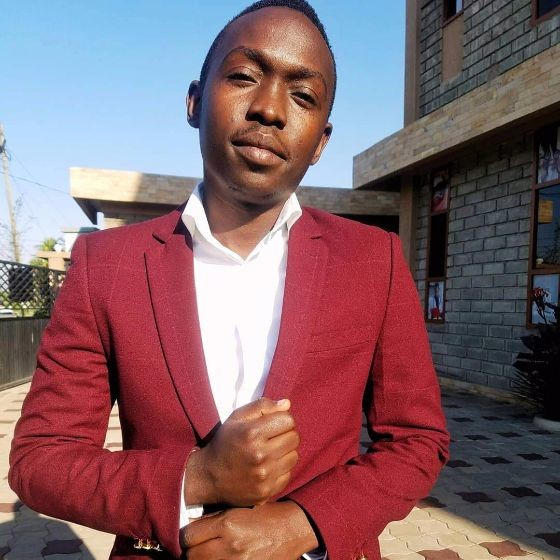

In [28]:
Image(requests.get(s.img['src']).content)

In [20]:
requests.get(s.img['src']).content

b'\xff\xd8\xff\xe0\x00\x10JFIF\x00\x01\x01\x00\x00\x01\x00\x01\x00\x00\xff\xdb\x00C\x00\x03\x02\x02\x03\x02\x02\x03\x03\x03\x03\x04\x03\x03\x04\x05\x08\x05\x05\x04\x04\x05\n\x07\x07\x06\x08\x0c\n\x0c\x0c\x0b\n\x0b\x0b\r\x0e\x12\x10\r\x0e\x11\x0e\x0b\x0b\x10\x16\x10\x11\x13\x14\x15\x15\x15\x0c\x0f\x17\x18\x16\x14\x18\x12\x14\x15\x14\xff\xdb\x00C\x01\x03\x04\x04\x05\x04\x05\t\x05\x05\t\x14\r\x0b\r\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\x14\xff\xc0\x00\x11\x08\x01\xf4\x01\xf4\x03\x01\x11\x00\x02\x11\x01\x03\x11\x01\xff\xc4\x00\x1e\x00\x00\x01\x04\x03\x01\x01\x01\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x02\x04\x06\x03\x05\x07\x08\t\n\xff\xc4\x00H\x10\x00\x01\x03\x02\x05\x02\x04\x04\x03\x06\x03\x07\x02\x04\x07\x00\x01\x00\x02\x03\x04\x11\x05\x06\x12!1\x07A\x13"Qa\x082q\x81\x14\x91\xa1\t\x15#B\xb1\xc1$R\xd1\x163br\x82\xe1\xf0%C\x17\x